#**Content-Aware Image Restoration (CARE)**
---

CARE is a neural network based architecture for image enhancement, first published in 2018 by Weigert et al. in Nature Methods (click [here](https://www.nature.com/articles/s41592-018-0216-7) to view the paper). The network allows image denoising and resolution improvement in 2D and 3D images, in a supervised manner, using noisy input and low-noise images as training data.

The code for this notebook is adapted from the author's [GitHub repository](https://github.com/csbdeep/csbdeep). Once the user is familiarised with functions of CARE, it can be instructive to explore in-depth features and functions of CARE in [this guide](http://csbdeep.bioimagecomputing.com/doc/) provided by the authors.

This notebook was adapted with the above code by Lucas von Chamier (Henriques Lab).

# **How to use this notebook?**
---


**- Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 5.1.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
**- Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
**- Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To edit a cell, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

*Original code:* all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

*Modified code:* the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

#**0. Before getting started with CARE**
---
<font size = 4> 
##**0.1 Data Format**

1. Create three folders which contain the 'source', 'target', and 'validation' files, respectively.
2. Make sure that source and corresponding targets have the same filenames.
3. The validation files should be completely unseen during training.
4. Put the folders into your google drive. If you want to run this notebook without manually changing code, don't nest the folders deeper within your google drive.

Your folder structure should look like this (after mounting your google drive, see 1.): </font>

- drive
  - My Drive
    - source
      - file_A, file_B, ...
    - target
      - file_A, file_B, ...
    - validation
      - file_X, file_Y, ...

**If you have these things sorted, you're ready to go!** 


  (To see the code, double-click on the relevant cell.)</font>

#**1. Connecting to Drive Data**
---
<font size = 4> Run the cell below and follow the link to connect the colab notebook to the drive containing your datasets. </font>



In [1]:
#Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**2. Install CARE**

In [0]:
#@title Play this cell to install CARE
!pip install csbdeep
from csbdeep import data
import os
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from tifffile import imsave
from csbdeep.utils import download_and_extract_zip_file, axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

os.chdir('/content/drive/My Drive')



#**3. Set up CARE network parameters**
---

##Notes on parameter choice
<font size = 4> **Input and target folders:** type the name of the input and target folders for training. Don't use '/' before the name of the folder.

<font size = 4> **Patch Size:** Smaller patch size leads to a larger training and validation set but to a reduction in information in the patch.

<font size = 4>**Patches per image:** Larger numbers may result in larger training set but can lead to RAM being overloaded and the notebook crashing

<font size = 4>**Training Steps per epoch:** Good network training may require at least 300 steps but will take a while.

<font size = 4>**Training Epochs:** More epochs can lead to overfitting of the final model.

<font size = 4>**Batch Size:** Smaller train_batch_size may yield slightly better performance but leads to longer training times. </font>

In [8]:
from keras.callbacks import ModelCheckpoint
from csbdeep import data
import os, json
import numpy as np
import keras.backend as K
from keras.callbacks import Callback

class HistoryCheckpoint(Callback):
    def __init__(self, fname='history.json', save_lr=True):
        self.save_lr = save_lr

    def on_train_begin(self, logs=None):
         self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.save_lr:
            logs['lr'] = K.get_value(self.model.optimizer.lr)
        for k,v in logs.items():
            self.history.setdefault(k,[]).append(np.float64(v))
        if self.history:
            with open(self.filepath,'w') as f:
                f.write(json.dumps(self.history))

#@markdown ### Are you training on 2D or 3D data?:
image_dimension = "2D" #@param ["2D", "3D"] {type:"string"}
#@markdown ### Enter an input folder name:
input_folder = "/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs" #@param {type:"string"}
#@markdown ---target_folder = 'Select Folder' #@param  {allow-input: true}
#@markdown ### Enter a target folder name:
target_folder = "Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Target_1" #@param {type:"string"}
#@markdown ---target_folder = 'Select Folder' #@param 

#@markdown ### Set CARE  training parameters

patch_size =   256#@param {type:"number"}

patches =   2#@param {type:"number"}

network_layers = 3#@param [1,2,3,4,5,6,7,8] {type:"raw"}

steps =   150#@param {type:"number"}

epochs =  30#@param {type:"number"}

batch_size = 8 #@param [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] {type:"raw"}

model_name = "my_model" #@param {type:"string"}

# For details on the objects created here, see CARE documentation:
# http://csbdeep.bioimagecomputing.com/doc/datagen.html

if image_dimension == "3D":
  raw_data = data.RawData.from_folder(basepath="/content/drive/My Drive", source_dirs=[input_folder], target_dir=target_folder, axes='CZYX', pattern='*.tif*')
  X, Y, XY_axes = data.create_patches(raw_data, patch_filter=None, patch_size=(4,patch_size,patch_size), n_patches_per_image=patches)
  print('Creating 3D training dataset')
else:
  raw_data = data.RawData.from_folder(basepath="/content/drive/My Drive", source_dirs=[input_folder], target_dir=target_folder, axes='CYX', pattern='*.tif*')
  X, Y, XY_axes = data.create_patches(raw_data, patch_filter=None, patch_size=(patch_size,patch_size), n_patches_per_image=patches)
  print ('Creating 2D training dataset')
np.savez("/content/drive/My Drive/train_array_google_new",X=X, Y=Y, axes=XY_axes)

(X,Y), (X_val,Y_val), axes = load_training_data('/content/drive/My Drive/train_array_google_new.npz', validation_split=0.1, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

# checkpoint
filepath="weights.h5"
checkpoint = HistoryCheckpoint()

config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=steps, train_epochs=epochs, unet_kern_size=5, unet_n_depth=network_layers, train_batch_size=batch_size, train_learning_rate=0.0004)
#print(config)
vars(config)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
model_training= CARE(config, name=filepath, basedir='.')

  629 raw images x    1 transformations   =   629 images
  629 images     x    2 patches per image =  1258 patches in total
Input data:
/content/drive/My Drive: target='Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Target_1', sources=['Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Source_1'], axes='CYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|██████████| 629/629 [00:21<00:00, 27.96it/s]


Creating 2D training dataset
number of training images:	 1132
number of validation images:	 126
image size (2D):		 (256, 256)
axes:				 SYXC
channels in / out:		 1 / 1


/usr/local/lib/python3.6/dist-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /content/drive/My Drive/weights.h5
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


#**4. Start Training**
---
<font size = 4> This step could take several hours depending on the size of the training set and the configuration of the network parameters.</font>

In [9]:
#@title Press play to train the model on your training data
history = model_training.train(X,Y, validation_data=(X_val,Y_val),callbacks=[checkpoint])

TypeError: ignored

#**5. View training history (optional)**
---
<font size = 4 >Running the below script will give an indication as to how well the network performs on the given data. If validation and training losses diverge this may be a sign for overfitting and may require resetting of training parameters in step 3. </font>

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


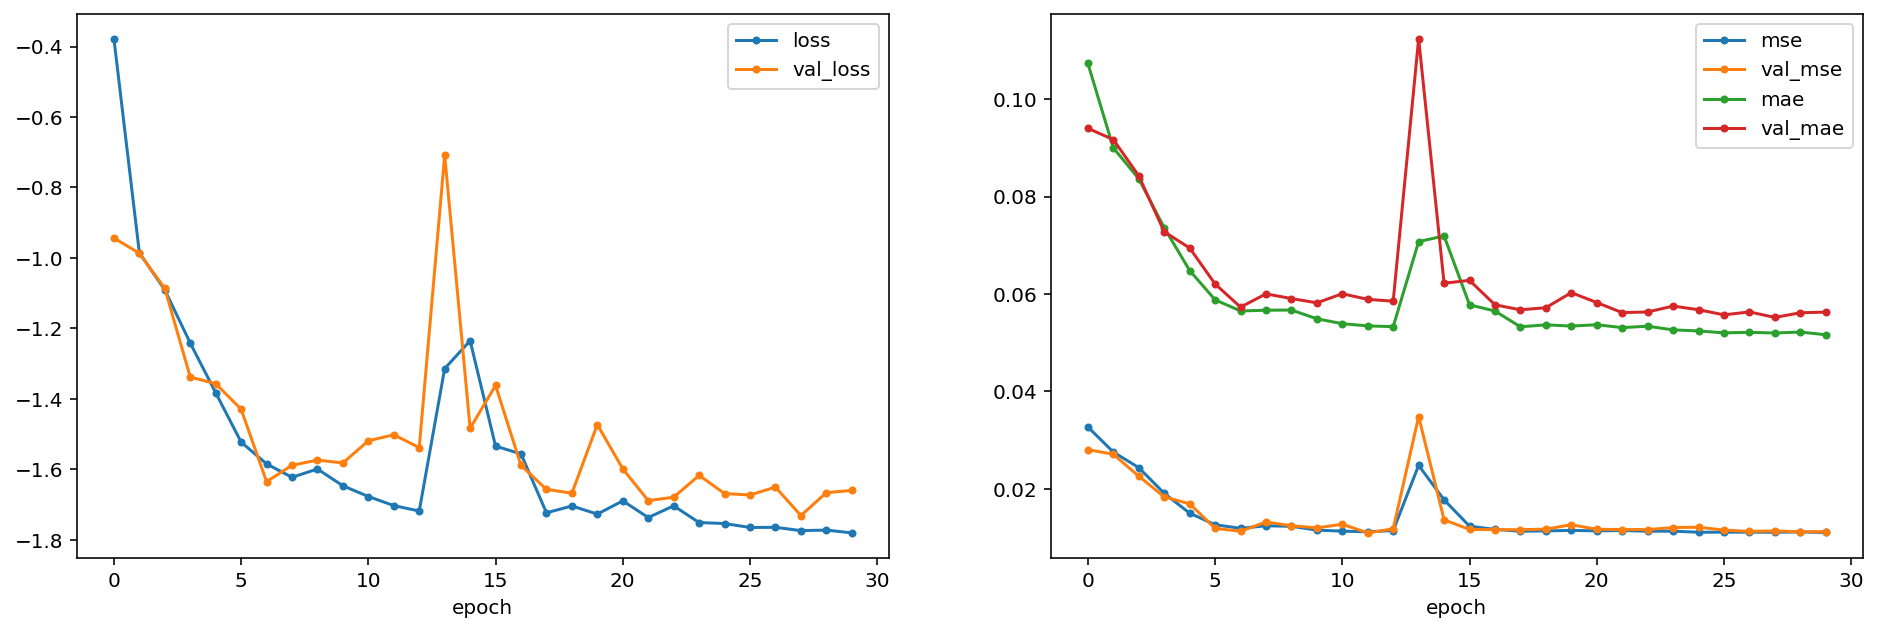

In [0]:
#@title Show the training history (optional)
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

#**6. Test model performance on an example**
---
<font size = 4> 
Ensure that no images in the validation folder have copies in the Source or Target folders used in training.
</font>

In [0]:
import os, random
from matplotlib import pyplot as plt
import shutil
#shutil.rmtree('/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Lucas CARE tifs/Test_1/.ipynb_checkpoints')
%matplotlib inline
#@markdown ### Enter the folder containing validation examples:
validation_folder = "/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Test_1" #@param {type:"string"}

ground_truth_folder = "/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Test_1" #@param {type:"string"}

results_folder = "/content/" #@param {type:"string"}
if not os.path.exists(results_folder):
  os.mkdir(results_folder)

# Select files from validation folder for inference

for filename in os.listdir(validation_folder):
  img = imread(os.path.join(validation_folder,filename))
  print(os.path.join(validation_folder,filename))
  if image_dimension == "3D":
    restored = model_training.predict(img, axes='ZYX')
  else:
    predict_model=CARE(name='weights-improvement-03--1.07.hdf5', config=None, basedir='/content/drive/My Drive/my_model')
    restored = predict_model.predict(img, axes='YX')
  os.chdir(results_folder)
  imsave("denoised_"+filename,restored)

# Pick a random image from the validation folder and display the result of inference.

# Random choice from validation folder
os.chdir("/content/drive/My Drive/")
random_choice=random.choice(os.listdir(validation_folder))
x = imread(validation_folder+"/"+random_choice)

#os.chdir("/content/drive/My Drive/"+validation_folder)
#os.chdir(results_folder)
#x = imread(random_choice)
#restored = model_training.predict(x, axes='ZYX')

f=plt.figure(figsize=(20,10))
plt.subplot(1,3,1)

if image_dimension == "3D":
  plt.imshow(x[0], interpolation='nearest')
else:
  plt.imshow(x, interpolation='nearest')
plt.title('Noisy Input')


plt.subplot(1,3,2)

# Get image inferred from random example from results folder.
os.chdir(results_folder)
y = imread('denoised_'+random_choice)
if image_dimension == "3D":
  plt.imshow(y[0], interpolation='nearest')
else:
  plt.imshow(y, interpolation='nearest')
plt.title('CARE Output')

# Get image showing ground truth for the validation example.
os.chdir("/content/drive/My Drive/")
z = imread(ground_truth_folder+"/"+random_choice)
plt.subplot(1,3,3)
if image_dimension == "3D":
  plt.imshow(z[0], interpolation='nearest')
else:
  plt.imshow(z, interpolation='nearest')
plt.title('Ground_truth')
#f.savefig('CARE test after image training - green channel test.png')
f.show()

/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/CSBDeep/Lucas CARE tifs/Test_1/pic1.tif


FileNotFoundError: ignored

In [0]:
#@markdown Play this cell to download the trained model, e.g. for use in Fiji or imageJ
model_training.export_TF()